In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None, first=500):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))[:first]  
        self.mask_filenames = sorted(os.listdir(mask_dir))[:first]  
        self.transform = transform
        self.mask_transform = mask_transform
        print(f'Loaded {len(self.image_filenames)} images and {len(self.mask_filenames)} masks.')

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
        
        image = Image.open(image_path).convert("RGB")  # Convert image to RGB (if it's not)
        mask = Image.open(mask_path).convert("L")      # Convert mask to grayscale

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask


# Paths to your images and masks directories
image_dir = 'train_hq/train_hq'
mask_dir = 'train_masks/train_masks'

# Define any transformations you need for your images and masks
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),         # Resize images to 256x256 (or any size you prefer)
    transforms.ToTensor(),                 # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),         # Resize mask to same size
    transforms.ToTensor(),                 # Convert mask to PyTorch tensor
])

# Create dataset
dataset = SegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, 
                              transform=image_transform, mask_transform=mask_transform)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)


Loaded 500 images and 500 masks.


## Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_, out_):
        super().__init__()
        self.double_conv  = nn.Sequential(
            nn.Conv2d(in_, out_, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_, out_, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

In [4]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        down = self.conv(x)
        pool = self.pool(down)
        return down, pool

In [5]:
class Up(nn.Module):
    def __init__(self, in_, out_):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_, in_//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_, out_)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        out = self.conv(x)
        return out

In [6]:
class OutConv(nn.Module):
    def __init__(self, in_, out_):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_, out_, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [7]:
class UNet(nn.Module):
    def __init__(self, in_, n_class):
        super().__init__()
        self.step_down = 64
        self.n_class = n_class

        self.down_1 = Down(in_, self.step_down)
        self.down_2 = Down(self.step_down, 2*self.step_down)
        self.down_3 = Down(2*self.step_down, 4*self.step_down)
        self.down_4 = Down(4*self.step_down, 8*self.step_down)

        self.neck = DoubleConv(8*self.step_down, 16*self.step_down)

        self.up_1 = Up(16*self.step_down, 8*self.step_down)
        self.up_2 = Up(8*self.step_down, 4*self.step_down)
        self.up_3 = Up(4*self.step_down, 2*self.step_down)
        self.up_4 = Up(2*self.step_down, self.step_down)

        self.out = OutConv(self.step_down, self.n_class)

    def forward(self, x):
        down1, pool1 = self.down_1(x)
        down2, pool2 = self.down_2(pool1)
        down3, pool3 = self.down_3(pool2)
        down4, pool4 = self.down_4(pool3)

        neck = self.neck(pool4)

        up1 = self.up_1(neck, down4)
        up2 = self.up_2(up1, down3)
        up3 = self.up_3(up2, down2)
        up4 = self.up_4(up3, down1)

        out = self.out(up4)
        return out

In [8]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, and optimizer
model = UNet(in_=3, n_class=1).to(device)  # For binary segmentation (n_class=1)
criterion = nn.BCEWithLogitsLoss()         # For binary segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [9]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=25):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            masks = masks.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    print("Training complete!")

# Train the model for a specified number of epochs
train_model(model, dataloader, criterion, optimizer, num_epochs=25)

Epoch 1/25: 100%|██████████| 16/16 [03:31<00:00, 13.19s/it]


Epoch [1/25], Loss: 0.4402


Epoch 2/25: 100%|██████████| 16/16 [09:19<00:00, 35.00s/it]


Epoch [2/25], Loss: 0.2530


Epoch 3/25: 100%|██████████| 16/16 [01:00<00:00,  3.77s/it]


Epoch [3/25], Loss: 0.2128


Epoch 4/25: 100%|██████████| 16/16 [01:45<00:00,  6.62s/it]


Epoch [4/25], Loss: 0.1950


Epoch 5/25: 100%|██████████| 16/16 [02:33<00:00,  9.61s/it]


Epoch [5/25], Loss: 0.1847


Epoch 6/25: 100%|██████████| 16/16 [02:41<00:00, 10.12s/it]


Epoch [6/25], Loss: 0.1760


Epoch 7/25: 100%|██████████| 16/16 [00:59<00:00,  3.74s/it]


Epoch [7/25], Loss: 0.1685


Epoch 8/25: 100%|██████████| 16/16 [00:59<00:00,  3.73s/it]


Epoch [8/25], Loss: 0.1612


Epoch 9/25: 100%|██████████| 16/16 [04:14<00:00, 15.91s/it]


Epoch [9/25], Loss: 0.1548


Epoch 10/25: 100%|██████████| 16/16 [00:59<00:00,  3.74s/it]


Epoch [10/25], Loss: 0.1493


Epoch 11/25: 100%|██████████| 16/16 [00:59<00:00,  3.71s/it]


Epoch [11/25], Loss: 0.1454


Epoch 12/25: 100%|██████████| 16/16 [01:00<00:00,  3.75s/it]


Epoch [12/25], Loss: 0.1398


Epoch 13/25: 100%|██████████| 16/16 [00:59<00:00,  3.74s/it]


Epoch [13/25], Loss: 0.1354


Epoch 14/25: 100%|██████████| 16/16 [00:59<00:00,  3.75s/it]


Epoch [14/25], Loss: 0.1302


Epoch 15/25: 100%|██████████| 16/16 [01:54<00:00,  7.14s/it]


Epoch [15/25], Loss: 0.1260


Epoch 16/25: 100%|██████████| 16/16 [00:55<00:00,  3.47s/it]


Epoch [16/25], Loss: 0.1217


Epoch 17/25: 100%|██████████| 16/16 [00:55<00:00,  3.47s/it]


Epoch [17/25], Loss: 0.1173


Epoch 18/25: 100%|██████████| 16/16 [00:55<00:00,  3.47s/it]


Epoch [18/25], Loss: 0.1151


Epoch 19/25: 100%|██████████| 16/16 [00:55<00:00,  3.49s/it]


Epoch [19/25], Loss: 0.1109


Epoch 20/25: 100%|██████████| 16/16 [00:55<00:00,  3.49s/it]


Epoch [20/25], Loss: 0.1071


Epoch 21/25: 100%|██████████| 16/16 [00:55<00:00,  3.49s/it]


Epoch [21/25], Loss: 0.1045


Epoch 22/25: 100%|██████████| 16/16 [00:55<00:00,  3.49s/it]


Epoch [22/25], Loss: 0.1008


Epoch 23/25: 100%|██████████| 16/16 [00:55<00:00,  3.48s/it]


Epoch [23/25], Loss: 0.0972


Epoch 24/25: 100%|██████████| 16/16 [00:55<00:00,  3.49s/it]


Epoch [24/25], Loss: 0.0944


Epoch 25/25: 100%|██████████| 16/16 [00:55<00:00,  3.49s/it]

Epoch [25/25], Loss: 0.0915
Training complete!


In [10]:
torch.save(model.state_dict(), "Unet.pth")

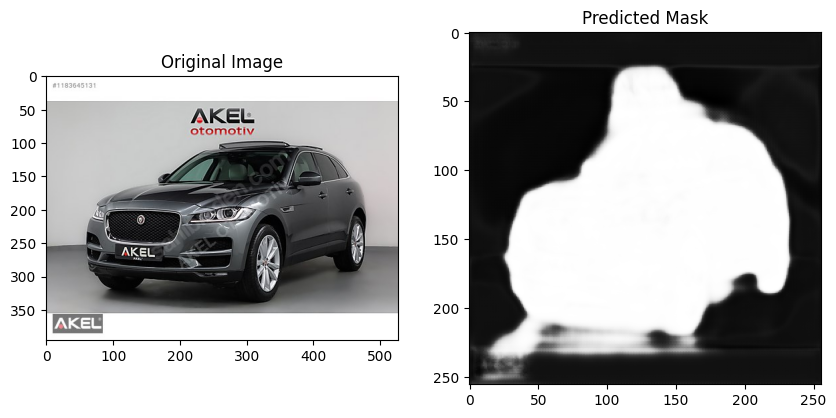

In [13]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess the image
image_path = 'img1.jpg'
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image_tensor = transform(image).unsqueeze(0).to(device)

# Initialize and load the model
model = UNet(in_=3, n_class=1).to(device) 
model.load_state_dict(torch.load('Unet.pth'))
model.eval()

# Make a prediction
with torch.no_grad():
    output = model(image_tensor)
output = torch.sigmoid(output).squeeze().cpu().numpy()

# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
if output.ndim == 2:  # Grayscale mask
    plt.imshow(output, cmap='gray')
else:  # RGB image
    plt.imshow(output)
plt.show()